In [45]:
import os
import sys
import numpy as np
import pandas as pd
import sys
sys.path.append("../")

from datatools.maneger import DataManager
from datatools.preproc import Preprocessor

In [46]:
out_path = "../../corpus/novel_formated/"
# corpus_name = "novel_segments2.tsv"
corpus_name = "ntt_segment.tsv"

In [47]:
import csv
conv_data = []
with open(out_path+corpus_name, "r") as f:
    reader = csv.reader(f, delimiter="\t")
    conv_data = [row for row in reader]

conv_only_utt = [ ["".join(conv[-3:-1]), conv[-1]] for conv in conv_data]

In [49]:
import random
random.seed(0)
def make_triple(conv_data):
    triple_list = []
    last_utts = [ conv[-1] for conv in conv_data if len(conv[-1]) > 6 ]
    neg_candidate = random.sample(last_utts, len(last_utts))
    for conv, neg in zip(conv_data, neg_candidate):
        # 短すぎる応答は殺す
        if len(conv[1]) <= 6:
            continue
        triple_list.append( [*conv , neg] )

    return triple_list

In [50]:
triple_list = make_triple(conv_only_utt)

mini_size = 10000
triple_list_mini = random.sample(triple_list,  mini_size)

In [25]:
from sentence_transformers import SentenceTransformer
# from sentence_transformers import models

# bert_path = "../../corpus/pretrained/sbert_unclear1"
bert_path = "../../corpus/pretrained/sbert_coherence"
sbert = SentenceTransformer(bert_path)

In [26]:
# 学習データ生成
# 全データのエンコード
triple_flatten = sum(triple_list_mini, [])
triple_vec = sbert.encode(triple_flatten).reshape(len(triple_list_mini), 3, -1)

In [27]:
import torch

def vec2feature(x, y):
    diff = np.abs( x - y )
    return np.concatenate([x, y, diff])


def make_X_y(triple_vec):
    X = []
    y = []
    for anc, pos, neg in triple_vec:
        # pos
        pos_f = vec2feature(anc, pos)
        X.append(pos_f)
        y.append(1)
        # neg
        neg_f = vec2feature(anc, neg)
        X.append(neg_f)
        y.append(0)
    return np.array(X), np.array(y)


In [28]:
X, y = make_X_y(triple_vec)

In [29]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=5, stratify=y)

In [30]:
class Datasets(torch.utils.data.Dataset):
    def __init__(self, X_data, y_data):
        # self.transform = transform

        self.X_data = X_data
        self.y_data = y_data

        self.datanum = len(X_data)

    def __len__(self):
        return self.datanum

    def __getitem__(self, idx):
        out_X = self.X_data[idx]
        out_y = self.y_data[idx]

        return out_X, out_y

In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules import loss
import torch.optim as optim

class CoherenceModel(nn.Module):
    def __init__(self, embedding_dim, tagset_size):
        # 親クラスのコンストラクタ。決まり文句
        super(CoherenceModel, self).__init__()    
        self.embedding_dim = embedding_dim
        self.hid1= embedding_dim*2
        self.hid2 = embedding_dim//2
        self.fc1 = nn.Linear(self.embedding_dim, self.hid1)
        self.fc2 = nn.Linear(self.hid1, self.hid2)
        # LSTMの出力を受け取って全結合してsoftmaxに食わせるための１層のネットワーク
        # self.hidden2tag = nn.Linear(self.hid2+self.fb_dim, tagset_size)
        self.hidden2tag = nn.Linear(self.hid2, tagset_size)
    
    def forward(self, x):
        y = F.relu(self.fc1(x))
        y = F.relu(self.fc2(y))
        y = self.hidden2tag( y )
        y = F.log_softmax(y, dim=1)
        return y

In [32]:
BATCH_SIZE = 64
epoch_ = 100
trainset = Datasets(X_train, y_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True, num_workers = 2)

In [33]:
EMBEDDING_DIM = 768*3
HIDDEN_DIM = EMBEDDING_DIM*2
OUTPUT_DIM = 2
# seq_len = length
print(EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)

2304 4608 2


In [34]:
model = CoherenceModel(EMBEDDING_DIM, OUTPUT_DIM)
if torch.cuda.is_available():
   model.cuda()
loss_function = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

In [35]:
losses = []
loss_border = 0.0001
for epoch in range(epoch_): 
    all_loss = 0
    for data in trainloader:
        # X_t_tensor = torch.tensor(data[0], device='cuda:0')
        X_t_tensor = data[0].cuda()
        # y_t_tensor = torch.tensor(data[1], device='cuda:0')
        y_t_tensor = data[1].cuda()
        optimizer.zero_grad()
        model.zero_grad()
        # print(X_t_tensor.shape)
        score = model(X_t_tensor)
        loss_ = loss_function(score, y_t_tensor)
        loss_.backward()
        all_loss += loss_.item()
        optimizer.step()
        del score
        del loss_
    losses.append(all_loss)
    if (epoch+1) % 5 == 0:
        print("epoch", epoch+1, "\t" , "loss", all_loss)
    # if all_loss <= loss_border:
    #     print("loss was under border(={0}) : train end".format(loss_border))
    #     break
print("done")

epoch 5 	 loss 127.25350272655487
epoch 10 	 loss 119.89729243516922
epoch 15 	 loss 113.73343002796173
epoch 20 	 loss 110.17737072706223
epoch 25 	 loss 105.67075926065445
epoch 30 	 loss 104.19298395514488
epoch 35 	 loss 98.73773795366287
epoch 40 	 loss 97.23666512966156
epoch 45 	 loss 88.93959091603756
epoch 50 	 loss 86.68876521289349


KeyboardInterrupt: 

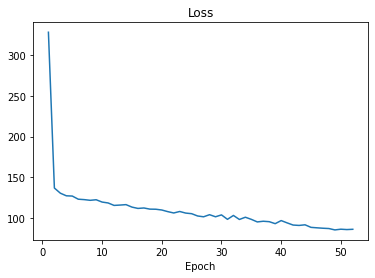

In [36]:
from matplotlib import pyplot as plt
def plot_history(losses):
    fig, ax = plt.subplots()

    epochs = np.arange(1, len(losses) + 1)

    # 損失の推移
    ax.set_title("Loss")
    ax.plot(epochs, losses)
    ax.set_xlabel("Epoch")

    plt.show()
plot_history(losses)

In [37]:
with torch.no_grad():
    X_tensor = torch.tensor(X_test, device='cuda:0').float()
    y_tensor = torch.tensor(y_test, dtype=torch.long, device='cuda:0')
            # 推論
    y_pred= np.array(model(X_tensor).cpu()).argmax(axis=1)

In [42]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
print('confusion matrix = \n', confusion_matrix(y_true=y_test, y_pred=y_pred))
print('accuracy = ', accuracy_score(y_true=y_test, y_pred=y_pred))
print('precision = ', precision_score(y_true=y_test, y_pred=y_pred))
print('recall = ', recall_score(y_true=y_test, y_pred=y_pred))
print('f1 = ', f1_score(y_true=y_test, y_pred=y_pred))

confusion matrix = 
 [[1947 1053]
 [1231 1769]]
accuracy =  0.6193333333333333
precision =  0.6268603827072998
recall =  0.5896666666666667
f1 =  0.6076949501889386


In [39]:
len(y_train)

14000

In [44]:
modelM = DataManager("../models/coherence/")
model_name = "sbert_coherence_DNN_ver{0}.pickle".format(1)
modelM.save_data(model_name, model)

success save : ../models/coherence/sbert_coherence_DNN_ver1.pickle
success save : ../models/coherence/sbert_coherence_DNN_ver1.pickle
